In [195]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from datetime import timedelta
from geopy.distance import geodesic
from tqdm import tqdm

from plotting import plot_time_distance, plot_matches_interactive_map, create_map_screenshot, plot_histogram, show_screenshots

matplotlib.use("module://matplotlib_inline.backend_inline")  # Keeps the backend interactive
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",  # Use pdflatex for LaTeX integration
    "font.family": "serif",  # Use a serif font matching LaTeX
    "text.usetex": True,  # Use TeX for text rendering
    "pgf.rcfonts": False,  # Prevent overriding LaTeX fonts
})

In [196]:
# read data from CSVs
modis_data = pd.read_csv('data/modis_2023_Germany.csv')
viirs_data = pd.read_csv('data/viirs-snpp_2023_Germany.csv')

In [197]:
# add 'timestamp' column calculated from "acq_date" and "acq_time"
modis_data['timestamp'] = pd.to_datetime(
    modis_data['acq_date'] + ' ' + modis_data['acq_time'].apply(lambda x: str(x).zfill(4)), format='%Y-%m-%d %H%M')
viirs_data['timestamp'] = pd.to_datetime(
    viirs_data['acq_date'] + ' ' + viirs_data['acq_time'].apply(lambda x: str(x).zfill(4)), format='%Y-%m-%d %H%M')

In [198]:
# remove low confidence detections
modis_data = modis_data[modis_data['confidence'] < 40]
viirs_data = viirs_data[viirs_data['confidence'] != 'l']
aqua_only_data = modis_data[modis_data['satellite'] == 'Aqua']
terra_only_data = modis_data[modis_data['satellite'] == 'Terra']

In [199]:
def cluster_fire_detections(df, spatial_threshold_km=1.0, temporal_threshold_hours=24):
    """
    Cluster fire detections into distinct fire events based on spatial and temporal proximity.

    Parameters:
    df: pandas DataFrame with columns: latitude, longitude, timestamp
        (timestamp should be in datetime format)
    spatial_threshold_km: float, maximum distance between points in same cluster (km)
    temporal_threshold_hours: float, maximum time difference between points in same cluster (hours)

    Returns:
    DataFrame with additional column 'event_id' identifying distinct fire events
    """
    # Convert temporal threshold to timedelta
    temporal_threshold = timedelta(hours=temporal_threshold_hours)

    # Sort by timestamp to process events chronologically
    df = df.sort_values('timestamp').copy()

    # Prepare coordinates for DBSCAN
    coords = df[['latitude', 'longitude']].values

    # Convert spatial threshold from km to degrees (approximate)
    # 111 km = 1 degree at the equator
    eps_degrees = spatial_threshold_km / 111.0

    # Perform spatial clustering
    clustering = DBSCAN(eps=eps_degrees, min_samples=1).fit(coords)
    df['spatial_cluster'] = clustering.labels_

    # Initialize event IDs
    df['event_id'] = -1
    current_event_id = 0

    # Process each spatial cluster
    for spatial_cluster in df['spatial_cluster'].unique():
        cluster_mask = df['spatial_cluster'] == spatial_cluster
        cluster_data = df[cluster_mask].copy()

        # Sort cluster points by time
        cluster_data = cluster_data.sort_values('timestamp')

        # Initialize first point as new event
        current_time = cluster_data.iloc[0]['timestamp']
        current_event_id += 1
        df.loc[cluster_data.index[0], 'event_id'] = current_event_id

        # Process remaining points
        for idx in cluster_data.index[1:]:
            point_time = df.loc[idx, 'timestamp']

            # Check if point is within temporal threshold
            if point_time - current_time <= temporal_threshold:
                df.loc[idx, 'event_id'] = current_event_id
            else:
                # Start new event
                current_event_id += 1
                df.loc[idx, 'event_id'] = current_event_id
                current_time = point_time

    return df

In [200]:
# Cluster fire detections
modis_data = cluster_fire_detections(modis_data)
aqua_only_data = cluster_fire_detections(aqua_only_data)
terra_only_data = cluster_fire_detections(terra_only_data)
viirs_data = cluster_fire_detections(viirs_data)

In [201]:
# count number of fire events
modis_event_count = modis_data['event_id'].nunique()
viirs_event_count = viirs_data['event_id'].nunique()
aqua_event_count = aqua_only_data['event_id'].nunique()
terra_event_count = terra_only_data['event_id'].nunique()
print(f'MODIS detected {modis_event_count} fire events')
print(f'VIIRS detected {viirs_event_count} fire events')
print(f'Aqua MODIS detected {aqua_event_count} fire events')
print(f'Terra MODIS detected {terra_event_count} fire events')

MODIS detected 470 fire events
VIIRS detected 4612 fire events
Aqua MODIS detected 227 fire events
Terra MODIS detected 285 fire events


In [202]:
def group_clusters(clustered_df):
    """
    Transform each cluster into a single representative point with earliest detection
    time and average location.

    Parameters:
    clustered_df: DataFrame with 'event_id' column from cluster_fire_detections
                 Must have columns: latitude, longitude, timestamp, satellite

    Returns:
    DataFrame with one row per cluster, containing earliest detection and mean location
    """
    consolidated = []

    for event_id in clustered_df['event_id'].unique():
        cluster = clustered_df[clustered_df['event_id'] == event_id]

        # Calculate mean location
        mean_lat = cluster['latitude'].mean()
        mean_lon = cluster['longitude'].mean()

        # Get earliest detection
        earliest_detection = cluster.loc[cluster['timestamp'].idxmin()]

        consolidated.append({
            'event_id': event_id,
            'latitude': mean_lat,
            'longitude': mean_lon,
            'timestamp': earliest_detection['timestamp'],
            'n_detections': len(cluster),
            # Preserve additional columns from earliest detection if they exist
            'confidence': earliest_detection.get('confidence', None),
            'brightness': earliest_detection.get('brightness', None),
            # Add spread metrics
            'lat_std': cluster['latitude'].std(),
            'lon_std': cluster['longitude'].std(),
            'time_span_hours': (cluster['timestamp'].max() -
                                cluster['timestamp'].min()).total_seconds() / 3600
        })

    return pd.DataFrame(consolidated)

In [203]:
modis_grouped = group_clusters(modis_data)
aqua_grouped = group_clusters(aqua_only_data)
terra_grouped = group_clusters(terra_only_data)
viirs_grouped = group_clusters(viirs_data)

In [204]:
def find_nearest_detections(modis_events, viirs_events, max_distance_km=5, max_time_hours=48):
    """
    For each MODIS event, find the nearest VIIRS detection in both space and time.

    Parameters:
    modis_events: DataFrame of MODIS detections with lat, lon, timestamp columns
    viirs_events: DataFrame of VIIRS detections with lat, lon, timestamp columns
    max_distance_km: Maximum allowed distance between matched events
    max_time_hours: Maximum allowed time difference between matched events

    Returns:
    DataFrame with matching results and time differences
    """
    matches = []
    max_time_diff = timedelta(hours=max_time_hours)

    for _, modis_event in tqdm(modis_events.iterrows()):
        modis_coords = (modis_event['latitude'], modis_event['longitude'])
        modis_time = modis_event['timestamp']

        # Filter VIIRS events within the time window to reduce computation
        time_mask = (abs(viirs_events['timestamp'] - modis_time) <= max_time_diff)
        candidate_viirs = viirs_events[time_mask]

        if len(candidate_viirs) == 0:
            continue

        # Calculate distances to all candidate VIIRS events
        distances = []
        time_diffs = []
        viirs_details = []

        for _, viirs_event in candidate_viirs.iterrows():
            viirs_coords = (viirs_event['latitude'], viirs_event['longitude'])
            distance = geodesic(modis_coords, viirs_coords).kilometers
            time_diff = (modis_time - viirs_event['timestamp']).total_seconds() / 60  # in minutes

            if distance <= max_distance_km:
                distances.append(distance)
                time_diffs.append(time_diff)
                viirs_details.append(viirs_event)

        if distances:
            # Find the closest match
            min_dist_idx = np.argmin(distances)
            viirs_event = viirs_details[min_dist_idx]

            matches.append({
                'modis_lat': modis_event['latitude'],
                'modis_lon': modis_event['longitude'],
                'modis_event_id': modis_event['event_id'],
                'modis_time': modis_time,
                'viirs_lat': viirs_event['latitude'],
                'viirs_lon': viirs_event['longitude'],
                'viirs_time': viirs_event['timestamp'],
                'distance_km': distances[min_dist_idx],
                'time_diff_minutes': time_diffs[min_dist_idx],  # positive means MODIS was later
                'modis_confidence': modis_event.get('confidence', None),
                'modis_brightness': modis_event.get('brightness', None)
            })
        else:
            # If no matches found, add a record with NaNs
            matches.append({
                'modis_lat': modis_event['latitude'],
                'modis_lon': modis_event['longitude'],
                'modis_event_id': modis_event['event_id'],
                'modis_time': modis_time,
                'distance_km': np.nan,
                'time_diff_minutes': np.nan,
                'modis_confidence': modis_event.get('confidence', None),
                'modis_brightness': modis_event.get('brightness', None)
            })

    return pd.DataFrame(matches)

In [205]:
# Find matching VIIRS detections for MODIS events, this takes around 1 minute
matches_modis_viirs = find_nearest_detections(modis_grouped, viirs_data)
matches_aqua_viirs = find_nearest_detections(aqua_grouped, viirs_data)
matches_terra_viirs = find_nearest_detections(terra_grouped, viirs_data)

470it [00:26, 17.50it/s]
227it [00:13, 17.30it/s]
285it [00:16, 16.93it/s]


In [206]:
# Count number of matches where distance is not NaN
valid_matches_modis = matches_modis_viirs[~matches_modis_viirs['distance_km'].isnull()]
print(f'Found {len(valid_matches_modis)} matching fire events for MODIS')
valid_matches_aqua = matches_aqua_viirs[~matches_aqua_viirs['distance_km'].isnull()]
print(f'Found {len(valid_matches_aqua)} matching fire events for Aqua MODIS')
valid_matches_terra = matches_terra_viirs[~matches_terra_viirs['distance_km'].isnull()]
print(f'Found {len(valid_matches_terra)} matching fire events for Terra MODIS')

Found 305 matching fire events for MODIS
Found 150 matching fire events for Aqua MODIS
Found 197 matching fire events for Terra MODIS


In [207]:
# Print summary statistics
def print_summary_statistics(matches, dataset_name):
    print(f"\nSummary Statistics for {dataset_name}")
    print(f"\tTotal matches: {len(matches)}")
    print(f"\tMean time difference: {matches['time_diff_minutes'].mean():.1f} minutes")
    print(f"\tMedian time difference: {matches['time_diff_minutes'].median():.1f} minutes")
    print(f"\tStandard deviation: {matches['time_diff_minutes'].std():.1f} minutes")
    print(f"\t{dataset_name} detected earlier: {sum(matches['time_diff_minutes'] < 0)} times")
    print(f"\tVIIRS detected earlier: {sum(matches['time_diff_minutes'] > 0)} times")

In [208]:
print_summary_statistics(valid_matches_modis, 'MODIS')
print_summary_statistics(valid_matches_aqua, 'Aqua MODIS')
print_summary_statistics(valid_matches_terra, 'Terra MODIS')


Summary Statistics for MODIS
	Total matches: 305
	Mean time difference: 60.4 minutes
	Median time difference: 13.0 minutes
	Standard deviation: 1515.8 minutes
	MODIS detected earlier: 151 times
	VIIRS detected earlier: 154 times

Summary Statistics for Aqua MODIS
	Total matches: 150
	Mean time difference: -77.4 minutes
	Median time difference: 24.0 minutes
	Standard deviation: 1522.3 minutes
	Aqua MODIS detected earlier: 70 times
	VIIRS detected earlier: 80 times

Summary Statistics for Terra MODIS
	Total matches: 197
	Mean time difference: 138.2 minutes
	Median time difference: -14.0 minutes
	Standard deviation: 1435.4 minutes
	Terra MODIS detected earlier: 99 times
	VIIRS detected earlier: 98 times


In [213]:
plot_matches_interactive_map(valid_matches_modis, save_html='maps/matches_modis_viirs.html')

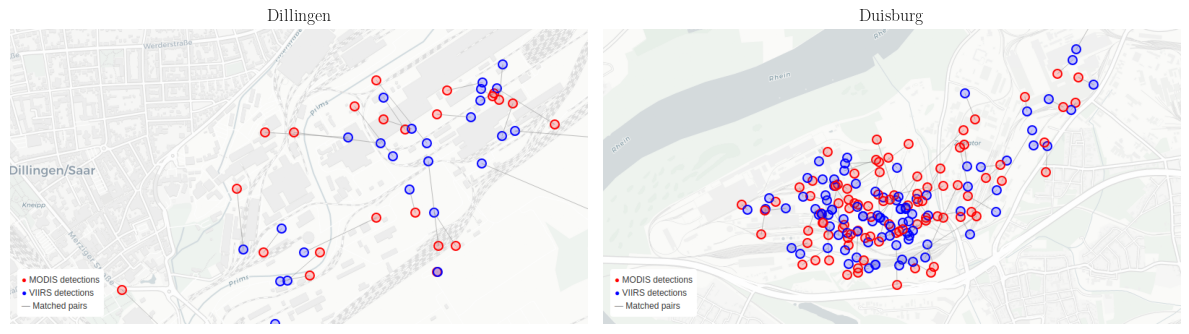

In [210]:
create_map_screenshot(
    matches_df=valid_matches_modis,
    center_coords=(49.355, 6.739),  # Dillingen coordinates
    zoom_level=14.5,
    output_file='maps/dillingen_detections.png'
)
create_map_screenshot(
    matches_df=valid_matches_modis,
    center_coords=(51.487, 6.72),
    zoom_level=14,
    output_file='maps/duisburg_detections.png'
)
show_screenshots('maps/dillingen_detections.png', 'maps/duisburg_detections.png', 'Dillingen', 'Duisburg')

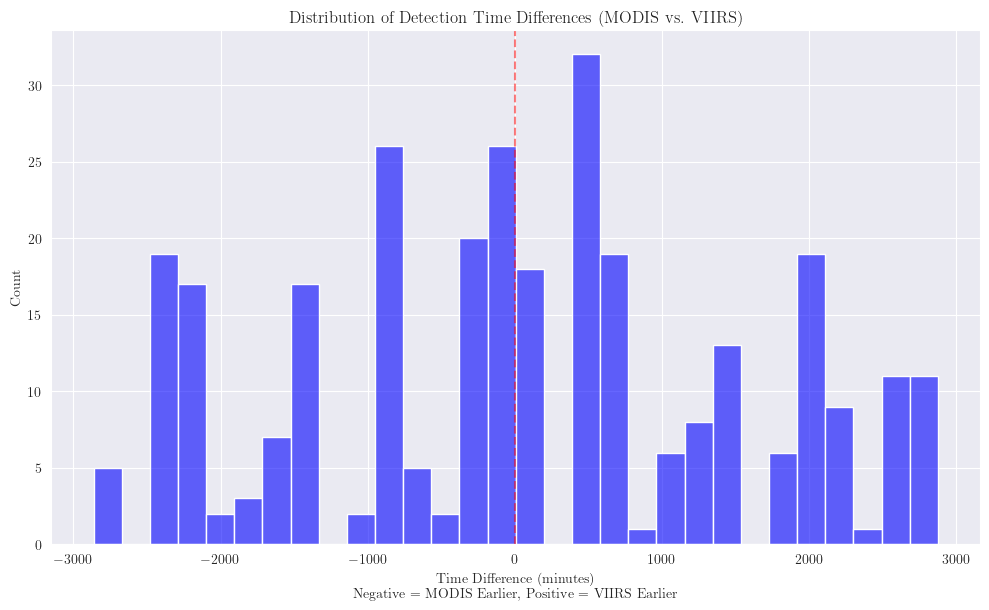

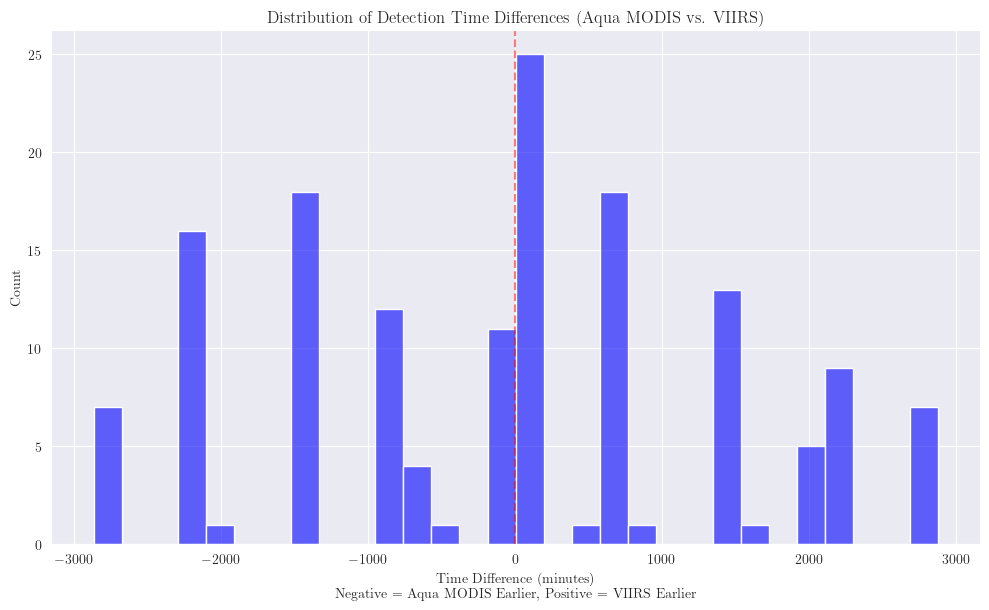

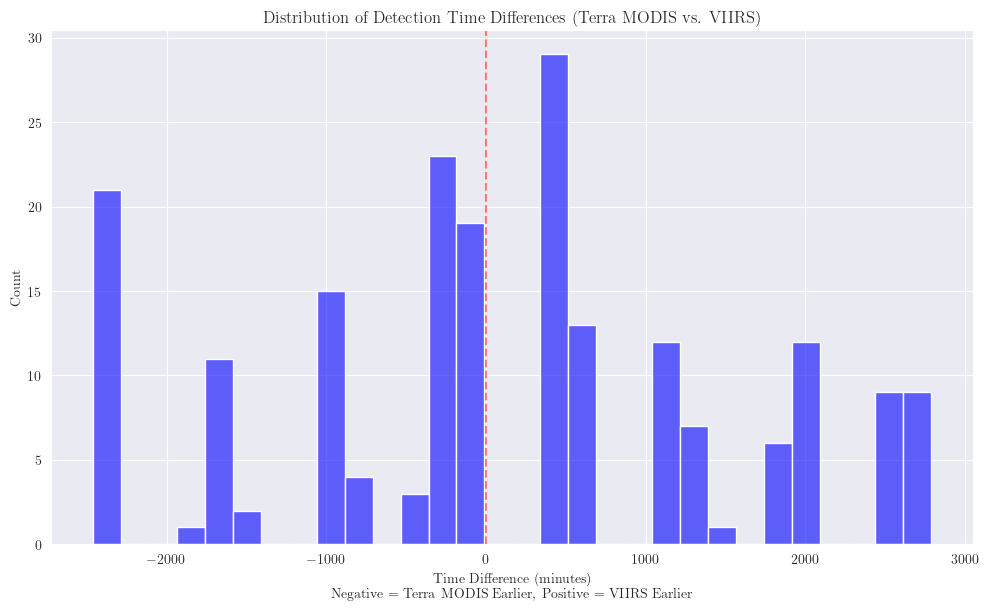

In [211]:
plot_histogram(valid_matches_modis, 'MODIS')
plot_histogram(valid_matches_aqua, 'Aqua MODIS')
plot_histogram(valid_matches_terra, 'Terra MODIS')

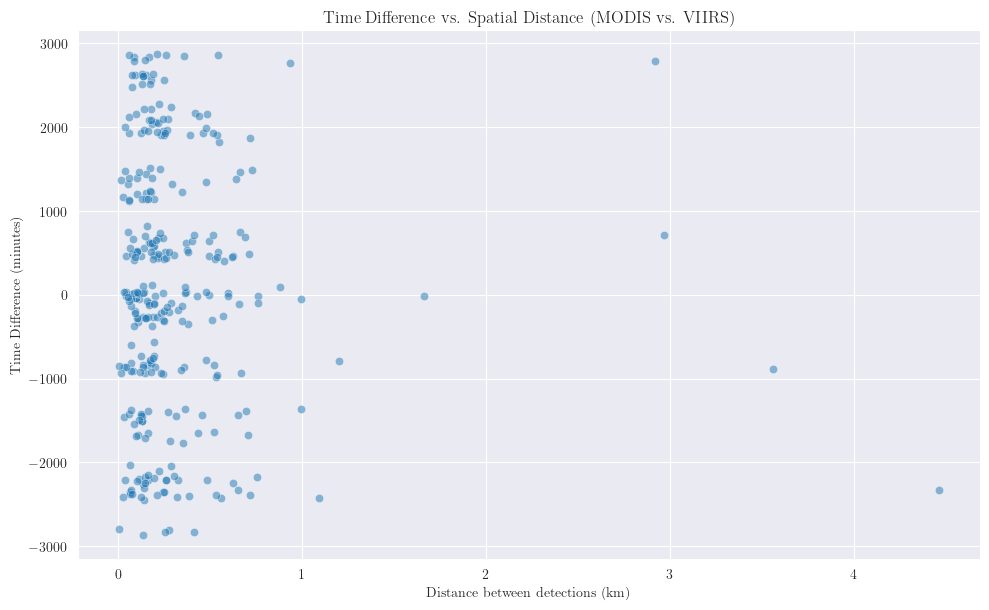

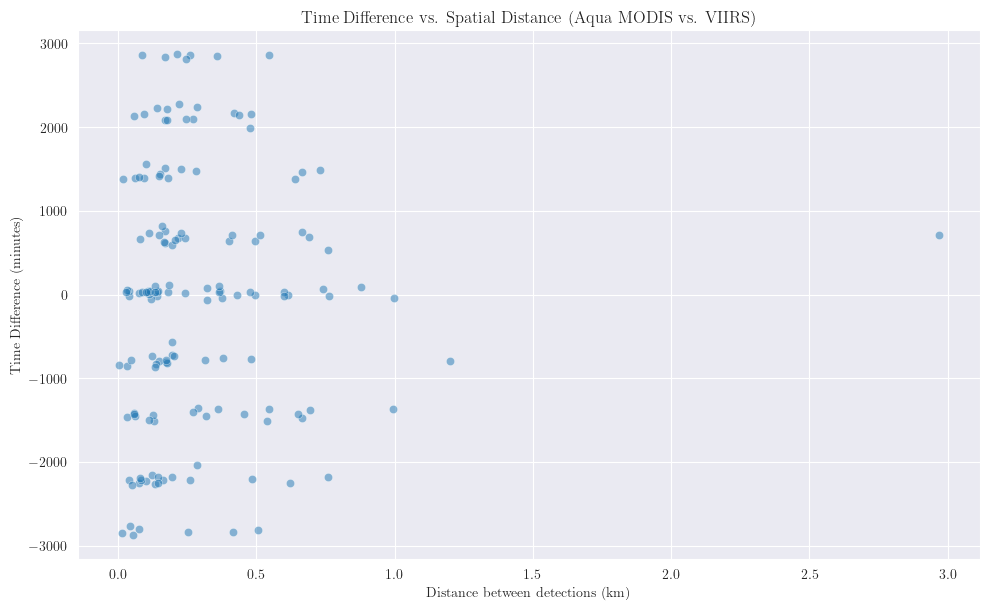

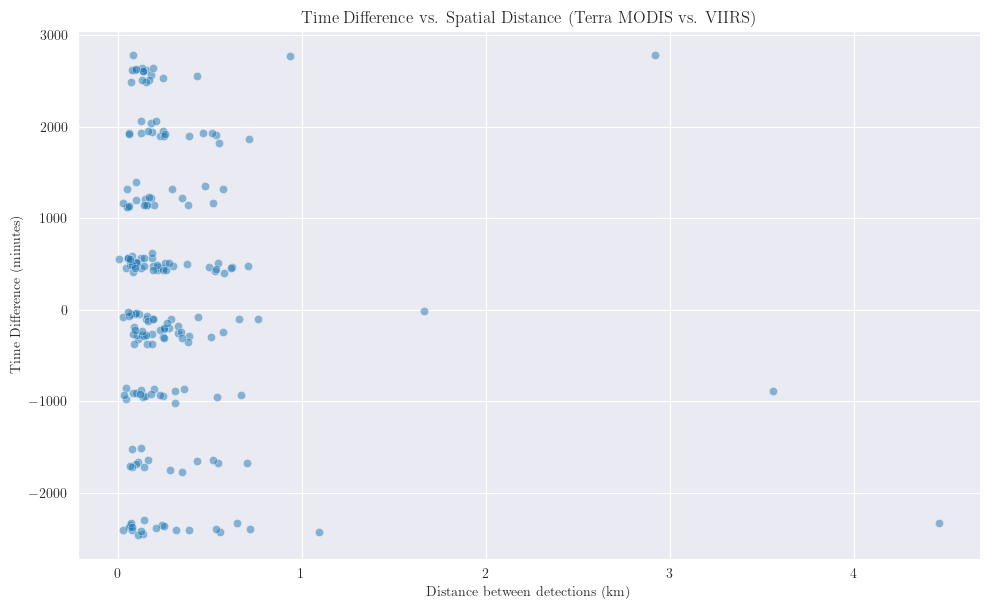

In [212]:
plot_time_distance(valid_matches_modis, 'MODIS')
plot_time_distance(valid_matches_aqua, 'Aqua MODIS')
plot_time_distance(valid_matches_terra, 'Terra MODIS')